In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ilhamnaufal","key":"4f87f3b865e073a6e6e939132aec991e"}'}

In [ ]:
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d marcosvolpato/edible-and-poisonous-fungi

 95% 243M/257M [00:01<00:00, 176MB/s]
100% 257M/257M [00:01<00:00, 159MB/s]


In [ ]:
import zipfile
#local_zip = '/content/mushrooms-classification-common-genuss-images.zip'
local_zip = '/content/edible-and-poisonous-fungi.zip'
zip_ref   = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/edible-and-poisonous-fungi')
zip_ref.close()

##Import Packages##

In [ ]:
import os
import seaborn as sns
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub 
import matplotlib.pyplot as plt
import sklearn
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix

## Common Functions

In [ ]:
def show_image(file_path):
    img = tf.keras.preprocessing.image.load_img(file_path, target_size=(228, 228))
    plt.imshow(img)
    plt.show()

# Preprocess image

In [ ]:
def preprocess_image(item):
    image_string = tf.io.read_file(item[0])
    image_decoded = tf.image.decode_jpeg(image_string, channels=3)
    image_resized = tf.image.resize(image_decoded, (IMAGE_SIZE, IMAGE_SIZE))
    image_resized = tf.cast(image_resized, tf.float32) / 255.0
    return image_resized, tf.strings.to_number(item[1], tf.int64)

# Get TFDS

In [ ]:
def get_dataset(edible_fungies, poisonous_fungies, mode, batch_size):
    x = list(edible_fungies) + list(poisonous_fungies)
    y = [0] * len(edible_fungies) + [1] * len(poisonous_fungies)
    items = [(a, b) for (a, b) in zip(x, y)]
    dataset = tf.data.Dataset.from_tensor_slices(np.array(items)).shuffle(len(x))
    dataset = dataset.map(preprocess_image).batch(batch_size)
    return dataset

## Get Balanced Dataset

In [ ]:
def get_balanced_dataset(edible_fungies, poisonous_fungies, batch_count, batch_size, mode="train"):
    length_per_category = batch_size * batch_count // 2
    edible_indices = np.random.choice(len(edible_fungies), length_per_category)
    poisonous_indices = np.random.choice(len(poisonous_fungies), length_per_category)
    samle_count = 2 * length_per_category
    return get_dataset(
        edible_fungies[edible_indices], 
        poisonous_fungies[poisonous_indices], 
        mode, 
        batch_size
    ), samle_count

## Import Dataset

In [ ]:
base_path = "/content/edible-and-poisonous-fungi/"
lables = ["edible", "poisonous"]
directory_group = [
    ['edible mushroom sporocarp', 'edible sporocarp'], 
    ['poisonous mushroom sporocarp', 'poisonous sporocarp']
]
edible_fungies = []
poisonous_fungies = []
for (label, directories) in zip(lables, directory_group):
    for directory in directories:
        items = os.listdir(base_path + directory)
        for item in items:
            file_path = base_path + directory + "/" + item
            if label == "edible":
                edible_fungies.append(file_path)
            else:
                poisonous_fungies.append(file_path)
edible_fungies = list(set(edible_fungies))
poisonous_fungies = list(set(poisonous_fungies))

In [ ]:
batch_size = 32
validation_split = 0.2
edible_fungies_split_index = int((1 - validation_split) * len(edible_fungies))
poisonous_fungies_split_index = int((1 - validation_split) * len(poisonous_fungies))
train_edible_fungies, valid_edible_fungies = edible_fungies[:edible_fungies_split_index],  edible_fungies[edible_fungies_split_index:] 
train_poisonous_fungies, valid_poisonous_fungies = poisonous_fungies[:poisonous_fungies_split_index],  poisonous_fungies[poisonous_fungies_split_index:] 
print("Train edible fungies: {}\nValid edible fungies: {}".format(len(train_edible_fungies), len(valid_edible_fungies)))
print("Train poisonous fungies: {}\nValid poisonous fungies: {}".format(len(train_poisonous_fungies), len(valid_poisonous_fungies)))
num_batch_per_epoch = min(len(train_edible_fungies), len(train_poisonous_fungies)) // batch_size
print("Number batch per epoch: ",num_batch_per_epoch)
num_epochs = 50
train_edible_fungies = np.array(train_edible_fungies)
valid_edible_fungies = np.array(valid_edible_fungies)
train_poisonous_fungies = np.array(train_poisonous_fungies)
valid_poisonous_fungies = np.array(valid_poisonous_fungies)
total_valid_count = len(valid_edible_fungies) + len(valid_poisonous_fungies)

Train edible fungies: 944
Valid edible fungies: 237
Train poisonous fungies: 1776
Valid poisonous fungies: 444
Number batch per epoch:  29


# EDA

### Number of Edible Fungies:

In [ ]:
len(edible_fungies)

1181

### Number of poisonous Fungies:

In [ ]:
len(poisonous_fungies)

2220

### File path of edible and poisonous fungies images:

In [ ]:
edible_fungies[:10]

['/content/edible-and-poisonous-fungi/edible sporocarp/ncvc (191).jpg',
 '/content/edible-and-poisonous-fungi/edible mushroom sporocarp/ce (7).jpg',
 '/content/edible-and-poisonous-fungi/edible mushroom sporocarp/ce (547).jpg',
 '/content/edible-and-poisonous-fungi/edible sporocarp/ncvc (321).jpg',
 '/content/edible-and-poisonous-fungi/edible mushroom sporocarp/ce (327).jpg',
 '/content/edible-and-poisonous-fungi/edible mushroom sporocarp/ce (411).jpg',
 '/content/edible-and-poisonous-fungi/edible sporocarp/ncvc (9).jpeg',
 '/content/edible-and-poisonous-fungi/edible sporocarp/ncvc (153).jpg',
 '/content/edible-and-poisonous-fungi/edible mushroom sporocarp/ce (157).jpg',
 '/content/edible-and-poisonous-fungi/edible mushroom sporocarp/ce (374).jpg']

In [ ]:
poisonous_fungies[:10]

['/content/edible-and-poisonous-fungi/poisonous mushroom sporocarp/cv (645).jpg',
 '/content/edible-and-poisonous-fungi/poisonous mushroom sporocarp/cv (305).jpg',
 '/content/edible-and-poisonous-fungi/poisonous sporocarp/nncv (461).jpg',
 '/content/edible-and-poisonous-fungi/poisonous mushroom sporocarp/cv (590).jpg',
 '/content/edible-and-poisonous-fungi/poisonous sporocarp/nncv (247).jpg',
 '/content/edible-and-poisonous-fungi/poisonous sporocarp/nncv (502).jpg',
 '/content/edible-and-poisonous-fungi/poisonous mushroom sporocarp/cv (369).jpg',
 '/content/edible-and-poisonous-fungi/poisonous mushroom sporocarp/cv (129).jpg',
 '/content/edible-and-poisonous-fungi/poisonous mushroom sporocarp/cv (224).jpg',
 '/content/edible-and-poisonous-fungi/poisonous sporocarp/nncv (11).jpg']

### Display file of edible fungies images:

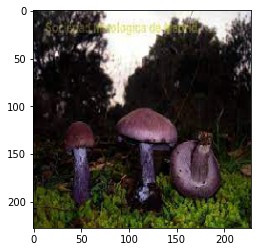

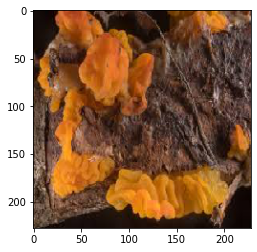

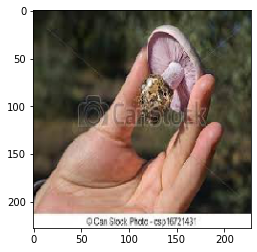

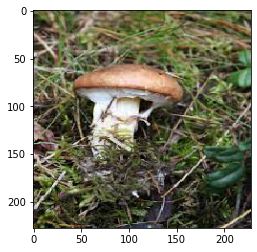

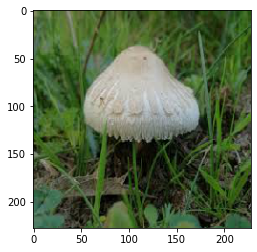

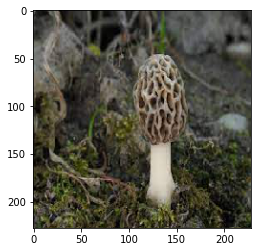

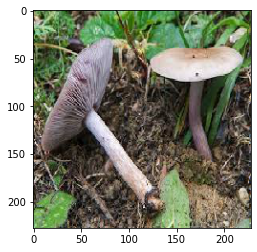

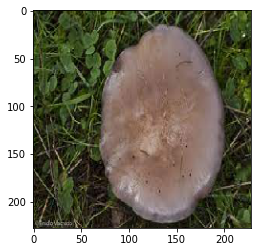

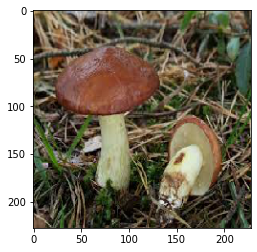

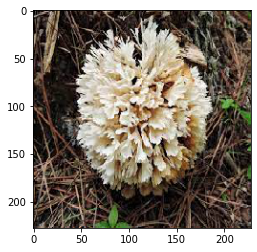

In [ ]:
for i in range(10):
    show_image(edible_fungies[np.random.randint(len(edible_fungies))])

### Display file of poisonous fungies images:

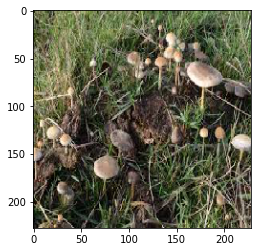

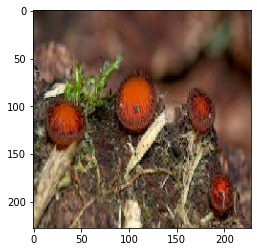

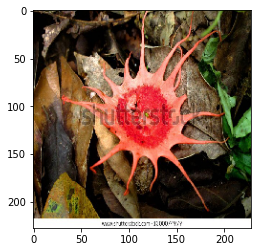

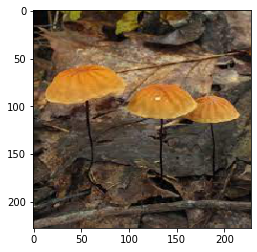

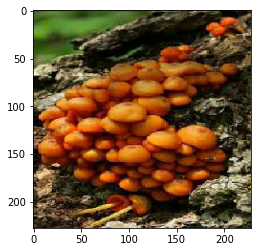

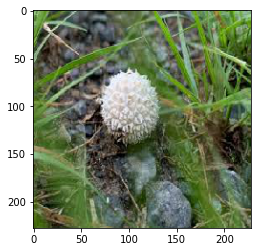

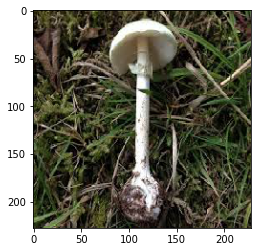

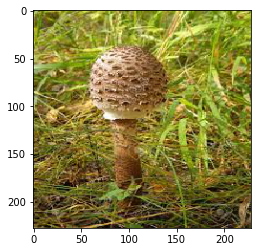

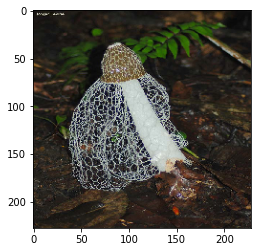

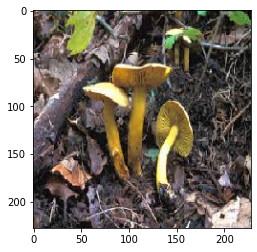

In [ ]:
for i in range(10):
    show_image(poisonous_fungies[np.random.randint(len(poisonous_fungies))])

# Model Development

## Model Building with Transfer Learning

In [ ]:
IMAGE_SIZE = 224
handle_base = "mobilenet_v2"
MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/{}/feature_vector/4".format(handle_base)
feature_extractor = hub.KerasLayer(MODULE_HANDLE,
                                    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
feature_extractor.trainable = False 

In [ ]:
tf.keras.backend.clear_session()
model = tf.keras.Sequential([
    feature_extractor,
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(2, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 32)                4128      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 2)                 6

## Model Training with Balanced Dataset and Custom Training Loop

In [ ]:
import time

valid_dataset = get_dataset(valid_edible_fungies, valid_poisonous_fungies, "valid", batch_size)
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy()
history = {
    "train_loss": [],
    "valid_loss": [],
    "train_accuracy": [],
    "valid_accuracy": []
}
for epoch in range(num_epochs):
    begin_time = time.time()
    train_dataset, total_train_count = get_balanced_dataset(train_edible_fungies, train_poisonous_fungies, num_batch_per_epoch, batch_size, mode="train")
    train_losses = []
    valid_losses = []
    correct_count = 0
    total_count = 0
    for (x_batch, y_true) in train_dataset:
        with tf.GradientTape() as tape:
            y_pred = model(x_batch)
            predict_labels = tf.argmax(y_pred, axis=-1)
            loss_value = loss(y_true, y_pred)
        gradients = tape.gradient(loss_value, model.trainable_weights)
        optimizer.apply_gradients(zip(gradients, model.trainable_weights))
        train_losses.append(loss_value)
        correct_count += tf.reduce_sum(tf.cast(y_true == predict_labels, tf.int64))
        total_count += y_true.shape[0]
    train_loss = tf.reduce_mean(train_losses)
    train_accuracy = correct_count / total_train_count
    history["train_loss"].append(train_loss)
    history["train_accuracy"].append(train_accuracy)
    correct_count = 0
    total_count = 0
    for (x_batch, y_true) in valid_dataset:
        y_pred = model(x_batch)
        predict_labels = tf.argmax(y_pred, axis=-1)
        loss_value = loss(y_true, y_pred)
        valid_losses.append(loss_value)
        correct_count += tf.reduce_sum(tf.cast(y_true == predict_labels, tf.int64))
        total_count += y_true.shape[0]
    valid_loss = tf.reduce_mean(valid_losses)
    valid_accuracy = correct_count / total_valid_count
    history["valid_loss"].append(valid_loss)
    history["valid_accuracy"].append(valid_accuracy)
    elapsed_time = time.time() -  begin_time
    print("Epoch: %d / %d"%(epoch + 1, num_epochs))
    print("%.2fs Loss: %.2f Accuracy: %.2f Validation Loss: %.2f Validation Accuracy: %.2f"%(elapsed_time, train_loss, train_accuracy, valid_loss, valid_accuracy))
for key in history:
    history[key] = list(np.array(history[key]))

Epoch: 1 / 50
24.62s Loss: 0.58 Accuracy: 0.68 Validation Loss: 0.50 Validation Accuracy: 0.76
Epoch: 2 / 50
12.26s Loss: 0.47 Accuracy: 0.78 Validation Loss: 0.47 Validation Accuracy: 0.76
Epoch: 3 / 50
12.21s Loss: 0.47 Accuracy: 0.77 Validation Loss: 0.54 Validation Accuracy: 0.72
Epoch: 4 / 50
9.64s Loss: 0.39 Accuracy: 0.83 Validation Loss: 0.46 Validation Accuracy: 0.78
Epoch: 5 / 50
12.81s Loss: 0.34 Accuracy: 0.85 Validation Loss: 0.44 Validation Accuracy: 0.79
Epoch: 6 / 50
9.30s Loss: 0.32 Accuracy: 0.86 Validation Loss: 0.42 Validation Accuracy: 0.80
Epoch: 7 / 50
9.63s Loss: 0.26 Accuracy: 0.90 Validation Loss: 0.46 Validation Accuracy: 0.80
Epoch: 8 / 50
13.15s Loss: 0.26 Accuracy: 0.91 Validation Loss: 0.42 Validation Accuracy: 0.79
Epoch: 9 / 50
10.14s Loss: 0.24 Accuracy: 0.90 Validation Loss: 0.42 Validation Accuracy: 0.81
Epoch: 10 / 50
12.89s Loss: 0.20 Accuracy: 0.93 Validation Loss: 0.41 Validation Accuracy: 0.82
Epoch: 11 / 50
10.19s Loss: 0.19 Accuracy: 0.93 Vali

# Model Evaluation

## Loss & Accuracy over time

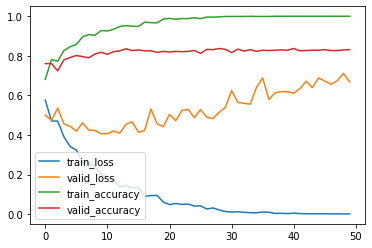

In [ ]:
pd.DataFrame(history).plot()

### Prediction with validation dataset

In [ ]:
predicted_labels = []
actual_labels = []
for (x_batch, y_true) in valid_dataset:
    y_pred = model(x_batch)
    predicted_labels += list(np.array(tf.argmax(y_pred, axis=-1)))
    actual_labels += list(np.array(y_true))

### Confusion Matrix

[[176  61]
 [ 54 390]]


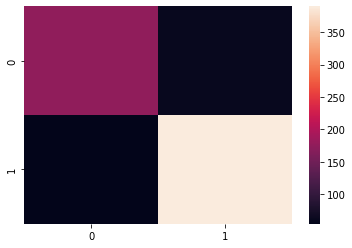

In [ ]:
matrix = confusion_matrix(actual_labels, predicted_labels)
print(matrix)
sns.heatmap(matrix)

### Classification Report

In [ ]:
cls_report = classification_report(predicted_labels, actual_labels)
print(cls_report)

              precision    recall  f1-score   support

           0       0.74      0.77      0.75       230
           1       0.88      0.86      0.87       451

    accuracy                           0.83       681
   macro avg       0.81      0.81      0.81       681
weighted avg       0.83      0.83      0.83       681



### Save the model

In [ ]:
model.save("shroomify_model.h5")

In [ ]:
MUSHROOM_SAVED_MODEL = "mushroom_saved_model"
# Use TensorFlow's SavedModel API to export the SavedModel from the trained Keras model
tf.saved_model.save(model, MUSHROOM_SAVED_MODEL)

INFO:tensorflow:Assets written to: mushroom_saved_model/assets


INFO:tensorflow:Assets written to: mushroom_saved_model/assets


In [ ]:
%%bash -s $MUSHROOM_SAVED_MODEL
saved_model_cli show --dir $1 --tag_set serve --signature_def serving_default

The given SavedModel SignatureDef contains the following input(s):
  inputs['keras_layer_input'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 224, 224, 3)
      name: serving_default_keras_layer_input:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['dense_2'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 2)
      name: StatefulPartitionedCall:0
Method name is: tensorflow/serving/predict


In [ ]:
loaded = tf.saved_model.load(MUSHROOM_SAVED_MODEL)

In [ ]:
print(list(loaded.signatures.keys()))
infer = loaded.signatures["serving_default"]
print(infer.structured_input_signature)
print(infer.structured_outputs)

['serving_default']
((), {'keras_layer_input': TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_layer_input')})
{'dense_2': TensorSpec(shape=(None, 2), dtype=tf.float32, name='dense_2')}


## Convert with TFLite's Converter

In [ ]:
# Intialize the TFLite converter to load the SavedModel
converter = tf.lite.TFLiteConverter.from_saved_model(MUSHROOM_SAVED_MODEL)

# Set the optimization strategy for 'size' in the converter 
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]

# Use the tool to finally convert the model
tflite_model = converter.convert()

In [ ]:
tflite_model_file = 'mushroom_model.tflite'

with open(tflite_model_file, "wb") as f:
    f.write(tflite_model)

## Test the TFLite Model Using the Python Interpreter

In [ ]:
# Load TFLite model and allocate tensors.
with open(tflite_model_file, 'rb') as fid:
    tflite_model = fid.read()
    
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

In [ ]:
valid_datasets = get_dataset(valid_edible_fungies, valid_poisonous_fungies, "valid", 1)

In [ ]:
valid_batches = valid_datasets

In [ ]:
# Gather results for the randomly sampled test images
predictions = []

test_labels, test_imgs = [], []
for img, label in tqdm(valid_batches.take(10)):
    interpreter.set_tensor(input_index, img)
    interpreter.invoke()
    predictions.append(interpreter.get_tensor(output_index))
    
    test_labels.append(label.numpy()[0])
    test_imgs.append(img)

100%|██████████| 10/10 [00:07<00:00,  1.37it/s]


In [ ]:
#@title Utility functions for plotting
# Utilities for plotting

class_names = ['edible', 'poisonous']

def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    img = np.squeeze(img)
    
    plt.imshow(img, cmap=plt.cm.binary)
    
    predicted_label = np.argmax(predictions_array)
    
    print(type(predicted_label), type(true_label))
    
    if predicted_label == true_label:
        color = 'green'
    else:
        color = 'red'
        
    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                         100*np.max(predictions_array),
                                         class_names[true_label]), color=color)

<class 'numpy.int64'> <class 'numpy.int64'>


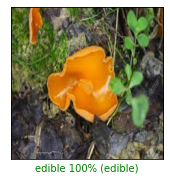

In [ ]:
#@title Visualize the outputs { run: "auto" }
index = 2 #@param {type:"slider", min:0, max:9, step:1}
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(index, predictions, test_labels, test_imgs)
plt.show()

In [ ]:
with open('labels.txt', 'w') as f:
    f.write('\n'.join(class_names))

In [ ]:
try:
    from google.colab import files
    files.download('mushroom_model.tflite')
    files.download('labels.txt')
except:
    pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>